<a href="https://colab.research.google.com/github/Nafew-I/Aircraft-Classification-Using-Sattelite-Imagery/blob/main/Baseline_Model_Aircraft_Classification_from_Satellite_Imagery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image Processing:

In [ ]:
batch_size = 64


train_dir = '/content/drive/MyDrive/APS360 project/Created Aircraft Dataset'

# Transform resizes the image, converts it to tensor, and normalizes it
transform = transforms.Compose([
    transforms.Resize((255, 255)),  # Resize to fit the model input size
    transforms.ToTensor(), # Converts to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), # Normalizes tensor
    transforms.GaussianBlur(kernel_size = (3,3), sigma = (3,8)), # Applies gaussian blur to images
    transforms.Grayscale(num_output_channels=1) # Converts images to black and white images
    # Fine-tuning
])

In [ ]:
# Preprocessing
dataset = datasets.ImageFolder(root=train_dir, transform=transform)
train_data, test_data, val_data = random_split(dataset, [0.8, 0.1, 0.1])

# Data loading:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, pin_memory=True)

# Baseline Model Definition:

In [ ]:
class LeNetCustom (nn.Module):
    def __init__(self):
      super(LeNetCustom, self).__init__()
      self.conv1 = nn.Conv2d(1, 6, 5)
      self.pool = nn.MaxPool2d(2, 2)
      self.conv2 = nn.Conv2d(6, 16, 5)
      self.fc1 = nn.Linear(16*60*60, 120)
      self.fc2 = nn.Linear(120, 84)
      self.fc3 = nn.Linear(84, 9)

    def forward(self, a):
      a = self.pool(nn.functional.relu(self.conv1(a)))
      a = self.pool(nn.functional.relu(self.conv2(a)))
      a = a.view(-1, 16*60*60)
      a = nn.functional.relu(self.fc1(a))
      a = nn.functional.relu(self.fc2(a))
      a = self.fc3(a)
      return a
base_model = LeNetCustom()

In [ ]:
# Fully-connected layer for classification
device = next(iter(trainloader))[0].device
base_model = base_model.to(device)

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters(), lr=0.001)

# Training and Validation:

In [ ]:
from tqdm import tqdm

def train(model, trainloader, num_epochs=10):
  losses, training_accuracy, vacc = [], [], []
  with tqdm(desc='Processing epochs', unit=' epochs completed') as pbar: # Progress bar to see how far model is to finish training
    for _ in range(num_epochs):
      model.train()
      for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(float(loss))
            loss.backward()
            optimizer.step()
      training_accuracy.append(accuracy(model, testloader, test_data))
      vacc.append(accuracy(model, valloader, val_data)) # Getting Validation accuracy using same method
      pbar.update(1)

  return training_accuracy, vacc, losses

In [ ]:
def accuracy(model, testloader, testset):
  model.eval()
  correct = 0.0

  for data in testloader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _,preds = outputs.max(1)
    correct += preds.eq(labels).sum()

  return (correct.float()/len(testset)).item()

In [ ]:
training_accuracy, training_losses, training_iter = train(base_model, trainloader, num_epochs=10) # Training the model and inputtting it into the validation model

Processing epochs: 10 epochs completed [19:26, 116.61s/ epochs completed]


# Plotting:

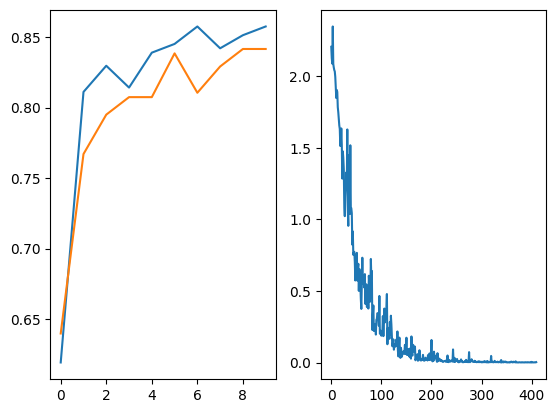

In [ ]:
#plotting all necessary info:

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(list(range(len(training_accuracy))), training_accuracy)
ax1.plot(list(range(len(training_losses))), training_losses)

ax2.plot(list(range(len(training_iter))), training_iter)